In [64]:
from datetime import datetime, date, timedelta
import json
import uuid
from enum import Enum
import random

# 3rd party modules
import boto3
import pandas as pd
import numpy as np

# Custom modules
from ModelRun import ModelRun

from ModelClasses import ModelTypes, EpiParams, Intervention, Result, ModelReport

from checkPlots import prep_plot

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
flu_dict = {
    'presymptomatic_period': 2,
    'duration_mild_infections': 4,
    'duration_asymp_infections': 4,
    'hospital_time_recovery': 11,
    'icu_time_death': 8,
    'beta_asymp': 0.4,
    'beta_mild': 0.4,
    'beta_hospitalized': 0.1,
    'beta_icu': 0.1,
    'percent_asymp': 0.33,
    'hospitalization_rate': 0.3,
    'hospitalized_cases_requiring_icu_care': 0.7,
    'death_rate_for_critical': 0.75,
}

pox_dict = {
    'presymptomatic_period': 6,
    'duration_mild_infections': 4,
    'hospital_time_recovery': 4,
    'icu_time_death': 2,
    'beta_asymp': 0.8,
    'beta_mild': 0.8,
    'beta_hospitalized': 0.1,
    'beta_icu': 0.1,
    'percent_asymp': 0,
    'hospitalization_rate': 0.25,
    'hospitalized_cases_requiring_icu_care': 0.5,
    'death_rate_for_critical': 0.8,
}

covid_15_dict = {
    'presymptomatic_period': 6,
    'duration_mild_infections': 6,
    'duration_asymp_infections': 6,
    'hospital_time_recovery': 11,
    'icu_time_death': 8,
    'beta_asymp': 0.28,
    'beta_mild': 0.28,
    'beta_hospitalized': 0.1,
    'beta_icu': 0.1,
    'percent_asymp': 0.3,
    'hospitalization_rate': 0.1,
    'hospitalized_cases_requiring_icu_care': 0.25,
    'death_rate_for_critical': 0.4,
}

disease_params = pox_dict
#disease_params = flu_dict
#disease_params = covid_15_dict

In [4]:
def run_model_with_params(city, run_type, timeseries, disease_params):
    
    modelrun = ModelRun(city,  run_type)
    modelrun.get_data(timeseries)
    modelrun.set_epi_model("asymp")

    for param_name, param_value in disease_params.items():
        setattr(modelrun, param_name, param_value)

    modelrun.epi_run.generate_epi_params()
    params = modelrun.epi_run.EpiParameters

    modelrun.run()
    display = modelrun.epi_run.display_df.copy()
    display["cum_cases"] = display["infected"].cumsum()

    display["pct_infected"] = display["cum_cases"] / modelrun.population
    
    return display
    
def run_city_country(city):

    cases = random.randint(5, 35)

    city_timeseries = {
        '2020-11-26': {'state': city, 'fips': '123', 
                       'cases': cases, 
                       'deaths': 0, 
                       'estimated_recovered': 0,
                       'active': cases,
                       'estimated_hospitalized': 0,
                       'estimated_infected': 0, 
                      },
    }
 



    city_df = run_model_with_params(city, 'city', city_timeseries, disease_params)
    
    country_outbreak_threshold = 10 / 100000

    country_outbreak_date = city_df.loc[(city_df.pct_infected >= country_outbreak_threshold), 'date'].min()

    country_outbreak_date_str = country_outbreak_date.strftime("%Y-%m-%d")
    
    country_cases = random.randint(50, 500)
    
    country_timeseries = {
        country_outbreak_date_str: {'state': city, 'fips': '123',
                                    'cases': country_cases,
                                    'deaths': '0',
                                    'estimated_recovered': 0,
                                    'active': country_cases,
                                    'estimated_hospitalized': 0,
                                    'estimated_infected': 0, 
                                    },
    }
    
    
    country_df = run_model_with_params(city, 'country', country_timeseries, disease_params)

    return {'city': city_df, 'country': country_df}

In [5]:
city = 'Arnica'
run_type = 'city'
cases = random.randint(30, 50)

city_timeseries = {
    '2021-2-19': {'state': city, 'fips': '123', 
                   'cases': cases, 
                   'deaths': 0, 
                   'estimated_recovered': 0,
                   'active': cases,
                   'estimated_hospitalized': 0,
                   'estimated_infected': 0, 
                  },
}

#d = run_model_with_params(city, 'city', city_timeseries, disease_params)
    
#print(d['R effective'].max())
#print(d['R effective'].min())


modelrun = ModelRun(city,  run_type)
modelrun.get_data(city_timeseries)
modelrun.set_epi_model("asymp")

for param_name, param_value in disease_params.items():
    setattr(modelrun, param_name, param_value)

modelrun.epi_run.generate_epi_params()
params = modelrun.epi_run.EpiParameters

modelrun.run()
display = modelrun.epi_run.display_df.copy()
display["cum_cases"] = display["infected"].cumsum()

display["pct_infected"] = display["cum_cases"] / modelrun.population

In [6]:
print(cases)
print(modelrun.population)

42
50000000.0


In [7]:
print(modelrun.percent_asymp)
print(modelrun.hospitalization_rate)
print(modelrun.hospitalized_cases_requiring_icu_care)
print(modelrun.death_rate_for_critical)

print((1 - modelrun.percent_asymp) * modelrun.hospitalization_rate * modelrun.hospitalized_cases_requiring_icu_care * modelrun.death_rate_for_critical)

print(modelrun.case_fatality_rate)

0
0.25
0.5
0.8
0.1
0.1


In [19]:
move_1_date = pd.Timestamp(datetime(2021, 2, 19).date() + timedelta(days = 21))

print(display.loc[(display['date'] == move_1_date), 'infected_a'].max())
print(display.loc[(display['date'] == move_1_date), 'infected'].max())
print(display.loc[(display['date'] == move_1_date), 'dead'].max())

1051.836818219652
1240.962240247009
67.71036782024834


In [9]:
display.head(1)

,date,exposed,infected_a,infected_b,infected_c,recovered,dead,asymp,source,R effective,infected,pct_change,doubling_time,cum_cases,pct_infected
0,2021-02-19,42.0,42.0,0.0,0.0,0.0,0.0,0.0,actuals,3.325,42.0,NaN,NaN,42.0,8.400000e-07


first case
2021-02-19 00:00:00
peak in hospitalizations
2021-03-12T00:00:00.000000000
158.95268418106897
peak in icu
2021-03-12T00:00:00.000000000
29.92707697217613
deaths
67.71036782024834


/Users/trae/.virtualenvs/ray-covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


interventions: None


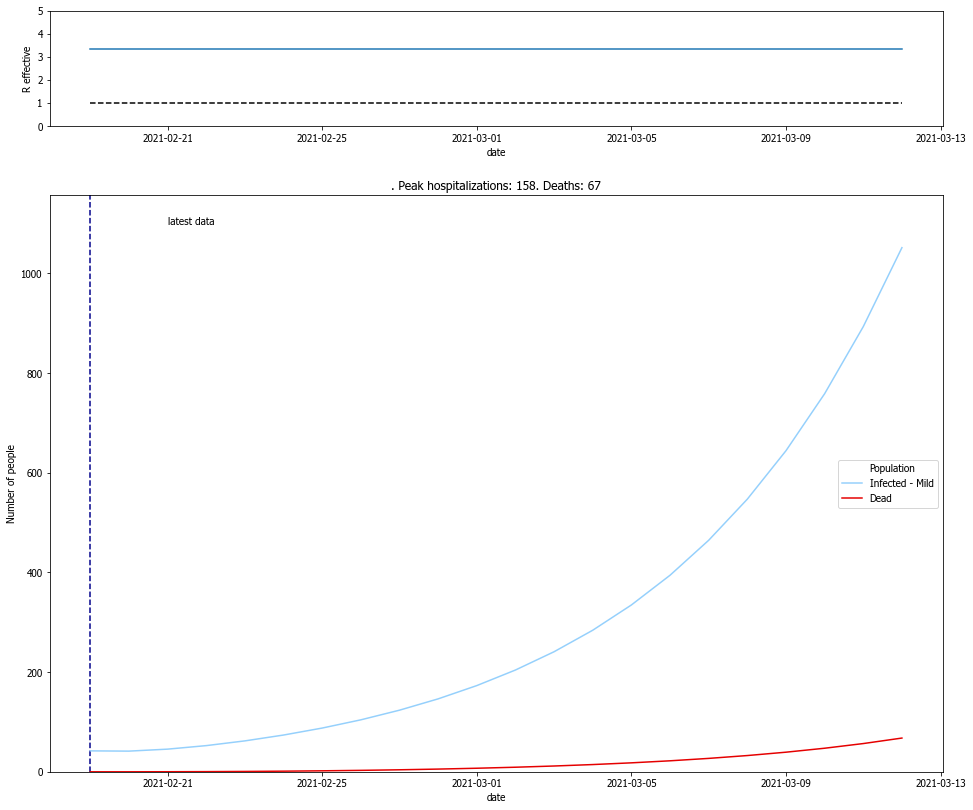

In [10]:
cols = ["infected_a", "dead", "R effective"]
prep_plot(display.loc[(display['date'] <= move_1_date), :], cols, line_day=datetime(2021,2,19), filename='flu_r=2.svg')

In [38]:
city = 'Arnica'
run_type = 'country'
cases = random.randint(100, 150)

city_timeseries = {
    '2021-3-19': {'state': city, 'fips': '123', 
                   'cases': cases, 
                   'deaths': 0, 
                   'estimated_recovered': 0,
                   'active': cases,
                   'estimated_hospitalized': 0,
                   'estimated_infected': 0, 
                  },
}

#d = run_model_with_params(city, 'city', city_timeseries, disease_params)
    
#print(d['R effective'].max())
#print(d['R effective'].min())


a_modelrun = ModelRun(city,  run_type)
a_modelrun.get_data(city_timeseries)
a_modelrun.set_epi_model("asymp")

for param_name, param_value in disease_params.items():
    setattr(a_modelrun, param_name, param_value)

a_modelrun.epi_run.generate_epi_params()
a_params = a_modelrun.epi_run.EpiParameters

a_modelrun.run()
a_display = a_modelrun.epi_run.display_df.copy()
a_display["cum_cases"] = a_display["infected"].cumsum()

a_display["pct_infected"] = a_display["cum_cases"] / a_modelrun.population

first case
2021-02-19 00:00:00
peak in hospitalizations
2021-05-18T00:00:00.000000000
1,529,895.2881609718
peak in icu
2021-05-20T00:00:00.000000000
376,737.8743106816
deaths
4,793,686.999702933
interventions: None


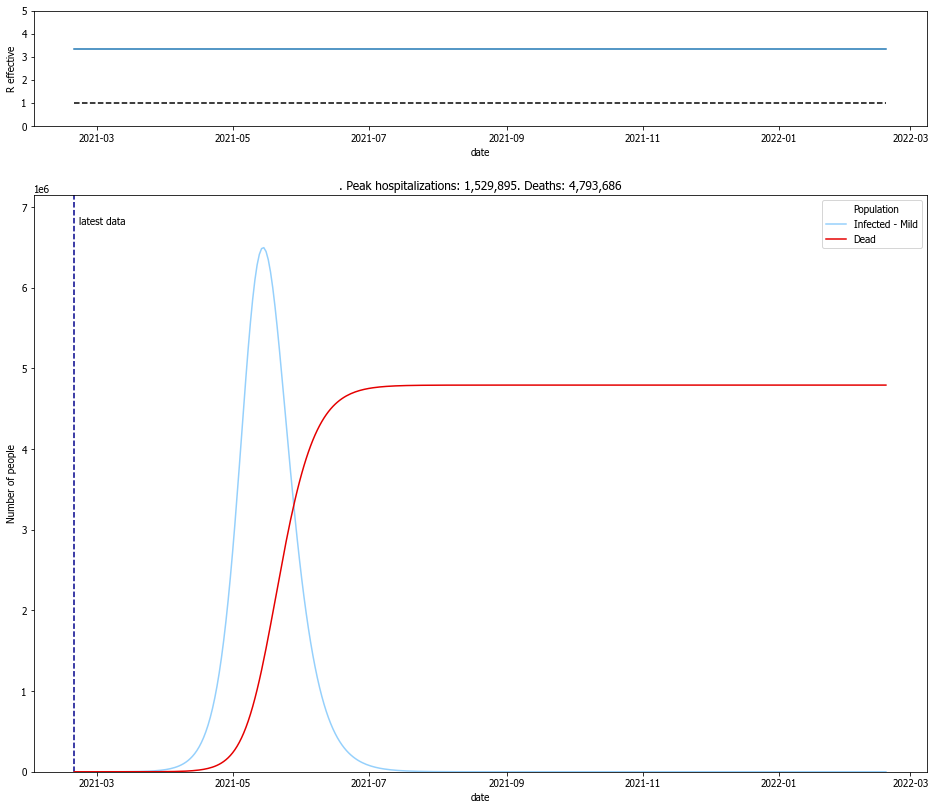

In [39]:
cols = ["infected_a", "dead", "R effective"]
prep_plot(display, cols, line_day=datetime(2021,2,19), filename='flu_r=2.svg')

first case
2021-03-19 00:00:00
peak in hospitalizations
2021-06-29T00:00:00.000000000
35,209,509.0765833
peak in icu
2021-07-01T00:00:00.000000000
8,670,107.281050704
deaths
110,254,816.21450874
interventions: None


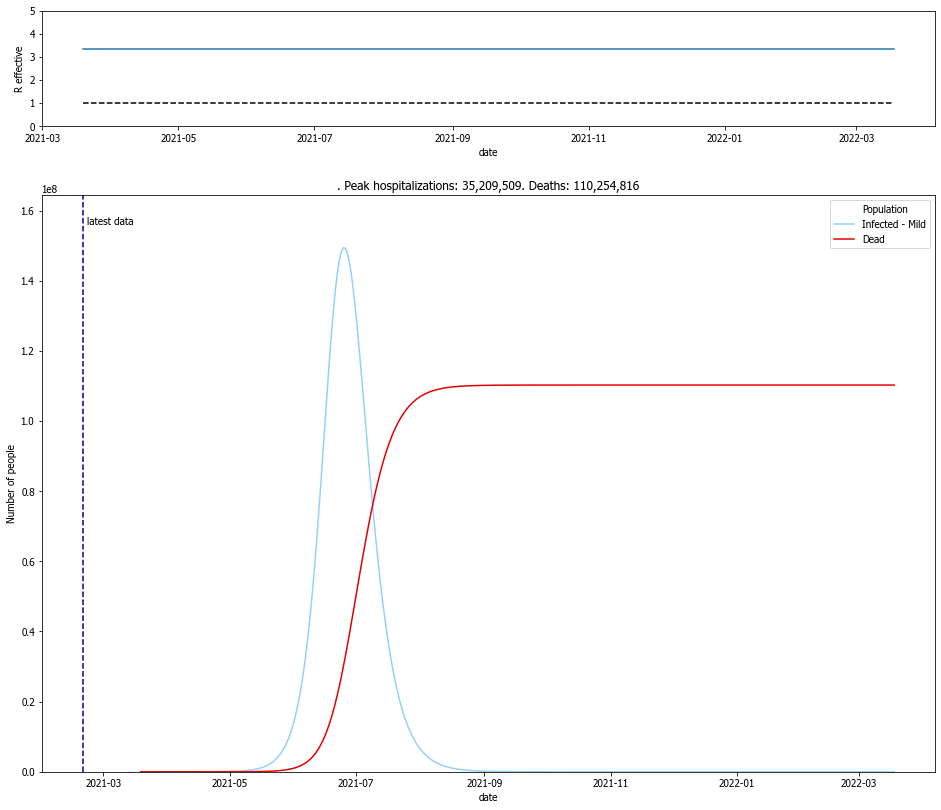

In [40]:
cols = ["infected_a", "dead", "R effective"]
prep_plot(a_display, cols, line_day=datetime(2021,2,19), filename='flu_r=2.svg')

In [41]:
move_2_date = pd.Timestamp(datetime(2021, 2, 19) + timedelta(days = 120))

print(a_display.loc[(a_display['date'] == move_2_date), 'infected_a'].values)
print(a_display.loc[(a_display['date'] == move_2_date), 'infected'].values)
print(a_display.loc[(a_display['date'] == move_2_date), 'dead'].values)

[1.23373225e+08]
[1.51247403e+08]
[15120687.79699536]


In [42]:
move_2_date

Timestamp('2021-06-19 00:00:00')

In [43]:
display.iloc[0, :]

date             2021-02-19 00:00:00
exposed                           42
infected_a                        42
infected_b                         0
infected_c                         0
recovered                          0
dead                               0
asymp                              0
source                       actuals
R effective                    3.325
infected                          42
pct_change                       NaN
doubling_time                    NaN
cum_cases                         42
pct_infected                 8.4e-07
Name: 0, dtype: object

In [44]:
a_display['date'].max()

Timestamp('2022-03-18 00:00:00')

In [45]:
#display.dtypes 

a_display.loc[(a_display['date'] ==  pd.Timestamp(2021, 6, 6)), :]

,date,exposed,infected_a,infected_b,infected_c,recovered,dead,asymp,source,R effective,infected,pct_change,doubling_time,cum_cases,pct_infected
79,2021-06-06,6.994474e+07,2.964492e+07,4.646867e+06,891610.385775,4.058867e+07,2.267418e+06,0.000012,base run,3.325,3.518340e+07,0.162937,4.254077,2.470684e+08,0.214842


In [46]:
add_cols = lambda s1, s2: s1 + s2

In [47]:
test_1 = display.set_index('date').drop('source', axis=1)
test_2 = a_display.set_index('date').drop('source', axis=1)

In [48]:
combo = test_1.combine(test_2, add_cols, fill_value=0)

combo.reset_index(inplace=True)

first case
2021-02-19 00:00:00
peak in hospitalizations
2021-06-29T00:00:00.000000000
35,257,550.13566702
peak in icu
2021-07-01T00:00:00.000000000
8,682,490.656224854
deaths
115,048,503.21411122
interventions: None


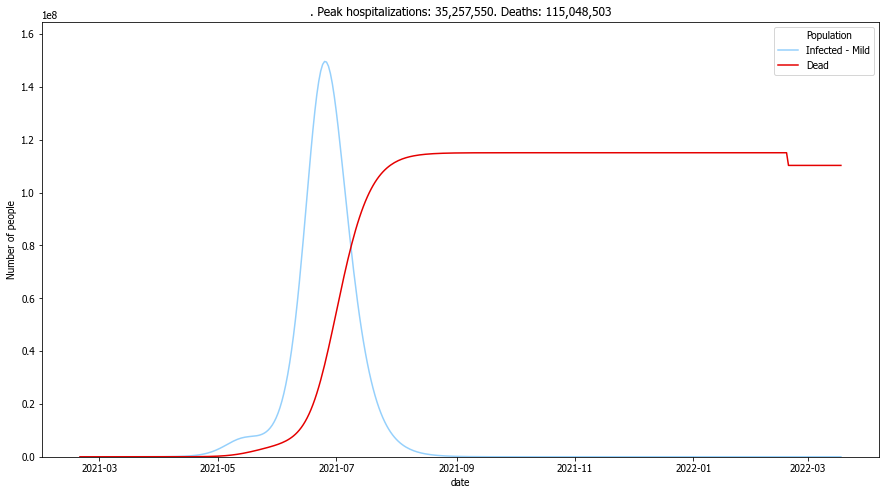

In [50]:
cols = ["infected_a", "dead"]
prep_plot(combo, cols, line_day=datetime(2021,2,19), filename='combo.svg')

In [53]:
35000000 / 1200000000 * 1000 / 0.58

50.287356321839084

In [ ]:
print(display.loc[(display['date'] < move_2_date), 'infected']

In [33]:
print(a_display.loc[(a_display['date'] < move_2_date), 'infected_a'].max())
print(a_display.loc[(a_display['date'] < move_2_date), 'infected'].max())
print(a_display.loc[(a_display['date'] < move_2_date), 'dead'].max())

148324250.29444847
180715790.4149835
14803229.341246305


In [34]:
display['week'] = display['date'].dt.strftime('%Y-w%U')

In [10]:
display.head()

,date,exposed,infected_a,infected_b,infected_c,recovered,dead,asymp,source,R effective,infected,pct_change,doubling_time,cum_cases,pct_infected
0,2021-02-19,233.000000,233.000000,0.000000,0.000000,0.000000,0.000000,0.000000,actuals,6.015,233.000000,NaN,NaN,233.000000,0.000002
0,2021-02-19,233.000000,233.000000,0.000000,0.000000,0.000000,0.000000,69.900000,base run,6.015,302.900000,NaN,NaN,535.900000,0.000005
1,2021-02-20,461.893743,251.405579,9.536288,0.208290,38.343627,0.007029,61.686533,base run,6.015,322.836690,NaN,NaN,858.736690,0.000009
2,2021-02-21,680.163035,300.879996,19.627904,0.807280,80.488039,0.054616,54.438175,base run,6.015,375.753355,NaN,NaN,1234.490045,0.000012
3,2021-02-22,915.044309,377.278213,31.362961,1.799478,130.177634,0.181547,48.041521,base run,6.015,458.482173,NaN,NaN,1692.972218,0.000017


In [36]:
display['date'].min()

Timestamp('2020-11-26 00:00:00')

In [38]:
display.loc[(display['date'] == '2020-12-21'), :]

,date,exposed,infected_a,infected_b,infected_c,recovered,dead,asymp,source,R effective,infected,pct_change,doubling_time,cum_cases,pct_infected,week
25,2020-12-21,61000.597108,26625.933221,3540.770074,457.158779,15598.62951,194.16955,1.318108,base run,6.015,30625.180181,0.250612,2.765813,152169.517008,0.15217,2020-w51


In [144]:
flu_weekly = display.groupby('week').max().reset_index()
flu_weekly['Hospitalized'] = flu_weekly['infected_b'] + flu_weekly['infected_c']
flu_weekly.head()

,week,date,exposed,infected_a,infected_b,infected_c,recovered,dead,asymp,source,R effective,infected,pct_change,doubling_time,cum_cases,pct_infected,Hospitalized
0,2020-w47,2020-11-28,291.830718,129.122106,8.423717,0.346466,34.543353,0.023440,30.000000,base run,6.015,161.256313,NaN,NaN,529.810341,0.000530,8.770184
1,2020-w48,2020-12-05,1666.474942,689.586938,82.797428,8.948065,352.659738,2.374508,20.618678,base run,6.015,791.072005,0.270425,3.572545,3583.034527,0.003583,91.745493
2,2020-w49,2020-12-12,8374.378297,3515.789647,450.639540,55.790110,1955.367467,20.775349,8.595144,base run,6.015,4026.279355,0.272080,2.645508,19209.161564,0.019209,506.429650
3,2020-w50,2020-12-19,40039.490294,17202.014589,2260.298489,289.426330,9921.927397,120.748901,3.582989,base run,6.015,19753.431893,0.261037,2.722366,96913.236313,0.096913,2549.724819
4,2020-w51,2020-12-26,153874.302268,73098.221748,10343.843468,1384.815387,46287.989901,614.828591,1.493612,base run,6.015,84827.586136,0.252816,3.018147,449270.263339,0.449270,11728.658855


In [145]:
flu_weekly.rename(columns = {
    'infected': 'Current cases',
    'cum_cases': 'Total cases',
    'dead': 'Dead',
    'week': 'Week',
}, inplace=True)

output_cols = ['Week', 'Total cases', 'Current cases', 'Hospitalized', 'Dead',]

flu_weekly = flu_weekly.loc[:, output_cols]

In [146]:
flu_weekly.to_csv('pox_weekly_summary-20201204.csv', index=False)

In [41]:
print(0.67 * 0.3 * 0.7 * 0.75)
print(0.3 * 0.5 * 0.8)

print(0.25 * 0.5 * 0.8)

0.105525
0.12
0.1


In [54]:
import folium
from folium.features import CustomIcon


m = folium.Map(location=[45.372, -121.6972], zoom_start=12, tiles="Stamen Terrain")

url = "http://leafletjs.com/examples/custom-icons/{}".format
icon_image = url("leaf-red.png")
shadow_image = url("leaf-shadow.png")

icon = CustomIcon(
    icon_image,
    icon_size=(38, 95),
    icon_anchor=(22, 94),
    shadow_image=shadow_image,
    shadow_size=(50, 64),
    shadow_anchor=(4, 62),
    popup_anchor=(-3, -76),
)

marker = folium.Marker(
    location=[45.3288, -121.6625], icon=icon, popup="Mt. Hood Meadows"
)


m.add_child(marker)

m

In [55]:
world_centroids = pd.read_csv('country_centroids_az8.csv')

world_cols = ['sovereignt', 'Longitude', 'Latitude', 'pop_est']
world = world_centroids.loc[:, world_cols]

world.rename(columns = {
    'sovereignt': 'country', 
    'Latitude': 'lat',
    'Longitude': 'lon',
    'pop_est': 'outbreak',
}, inplace=True)

world = world.sort_values('outbreak').drop_duplicates(subset='country', keep='last')

world.loc[world['country'] == 'United States of America', 'lat'] = 39.8283
world.loc[world['country'] == 'United States of America', 'lon'] = -98.5475

In [57]:
r_value = ['high', 'med', 'low']

world['r_range'] = np.random.choice(r_value, size=len(world))

In [58]:
low = world.loc[(world['r_range'] == 'low'), :]
med = world.loc[(world['r_range'] == 'med'), :]
high = world.loc[(world['r_range'] == 'high'), :]

In [158]:
high_dict = {
    'presymptomatic_period': 6,
    'duration_mild_infections': 4,
    'hospital_time_recovery': 4,
    'icu_time_death': 2,
    'beta_asymp': 0.8,
    'beta_mild': 0.8,
    'beta_hospitalized': 0.1,
    'beta_icu': 0.1,
    'percent_asymp': 0,
    'hospitalization_rate': 0.25,
    'hospitalized_cases_requiring_icu_care': 0.5,
    'death_rate_for_critical': 0.8,
}

med_dict = {
    'presymptomatic_period': 6,
    'duration_mild_infections': 4,
    'hospital_time_recovery': 4,
    'icu_time_death': 2,
    'beta_asymp': 0.4,
    'beta_mild': 0.4,
    'beta_hospitalized': 0.1,
    'beta_icu': 0.1,
    'percent_asymp': 0,
    'hospitalization_rate': 0.25,
    'hospitalized_cases_requiring_icu_care': 0.5,
    'death_rate_for_critical': 0.8,
}

low_dict = {
    'presymptomatic_period': 6,
    'duration_mild_infections': 4,
    'hospital_time_recovery': 4,
    'icu_time_death': 2,
    'beta_asymp': 0.13,
    'beta_mild': 0.13,
    'beta_hospitalized': 0.1,
    'beta_icu': 0.1,
    'percent_asymp': 0,
    'hospitalization_rate': 0.25,
    'hospitalized_cases_requiring_icu_care': 0.5,
    'death_rate_for_critical': 0.8,
}

disease_params = high_dict

In [159]:
def gen_outbreak(countries, name, start, interventions=[]):
    city = name
    run_type = 'country'
    
    pop = countries['outbreak'].sum()
    cases = pop * 0.00001

    city_timeseries = {
        start: {'state': city, 'fips': '123', 
                       'cases': cases, 
                       'deaths': 0, 
                       'estimated_recovered': 0,
                       'active': cases,
                       'estimated_hospitalized': 0,
                       'estimated_infected': 0, 
                      },
    }

    #d = run_model_with_params(city, 'city', city_timeseries, disease_params)

    #print(d['R effective'].max())
    #print(d['R effective'].min())


    modelrun = ModelRun(city, run_type, population=pop)
    modelrun.get_data(city_timeseries)
    modelrun.set_epi_model("asymp")

    for param_name, param_value in disease_params.items():
        setattr(modelrun, param_name, param_value)
        
    modelrun.epi_run.generate_epi_params()
    params = modelrun.epi_run.EpiParameters
    
    modelrun.run()
        
    for intervention in interventions:
        modelrun.add_intervention(intervention)
            
    if len(interventions) > 0:
        modelrun.run_all_interventions()
        intervention_name = interventions[-1].system_name
        display = modelrun.interventions[intervention_name].display_df.copy()

    else:
        display = modelrun.epi_run.display_df.copy()

    display["cum_cases"] = display["infected"].cumsum()

    display["pct_infected"] = display["cum_cases"] / modelrun.population
    
    return display

In [160]:
from ModelClasses import ModelTypes, EpiParams, Intervention

In [168]:
low.loc[:, 'percent_of_total'] = low['outbreak'] / low['outbreak'].sum()

low_params = EpiParams(beta_mild=0.13, beta_asymp=0)

low_intervention = Intervention(
    name='low_countries',
    system_name='low_2021_06_15',
    intervention_type='intervention',
    startdate='2021-06-15',
    intervention_start_date = '2021-06-15',
    model_start_date = '2021-06-15',
    params=low_params,
)

low_display = gen_outbreak(low, 'low countries', '2021-06-01', interventions=[low_intervention])

/Users/trae/.virtualenvs/ray-covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
0      low_countries
1      low_countries
2      low_countries
3      low_countries
4      low_countries
           ...      
360    low_countries
361    low_countries
362    low_countries
363    low_countries
364    low_countries
Name: source, Length: 365, dtype: object


In [169]:
low_display.head()

,date,exposed,infected_a,infected_b,infected_c,recovered,dead,asymp,source,R effective,infected,pct_change,doubling_time,cum_cases,pct_infected
0,2021-06-01,40060.708400,40060.708400,0.000000,0.000000,0.000000,0.000000,0.000000,actuals,3.325,40060.708400,NaN,NaN,40060.708400,0.000010
0,2021-06-01,40060.708400,40060.708400,0.000000,0.000000,0.000000,0.000000,12018.212520,base run,3.325,52078.920920,NaN,NaN,92139.629320,0.000023
1,2021-06-02,71088.831730,39574.665843,2177.151538,120.589025,9584.579708,17.137503,9963.448128,base run,3.325,51835.854534,NaN,NaN,143975.483854,0.000036
2,2021-06-03,97548.218889,43366.703647,3977.407904,384.894005,19421.295440,115.176643,8259.988615,base run,3.325,55988.994171,NaN,NaN,199964.478025,0.000050
3,2021-06-04,122957.171943,50107.424628,5678.230192,715.302577,30215.132549,333.653610,6847.771078,base run,3.325,63348.728476,NaN,NaN,263313.206501,0.000066


first case
2021-06-01 00:00:00
peak in hospitalizations
2021-06-19T00:00:00.000000000
60,547.479893352946
peak in icu
2021-06-22T00:00:00.000000000
14,647.167111647725
deaths
230,592.38678419724
interventions: None


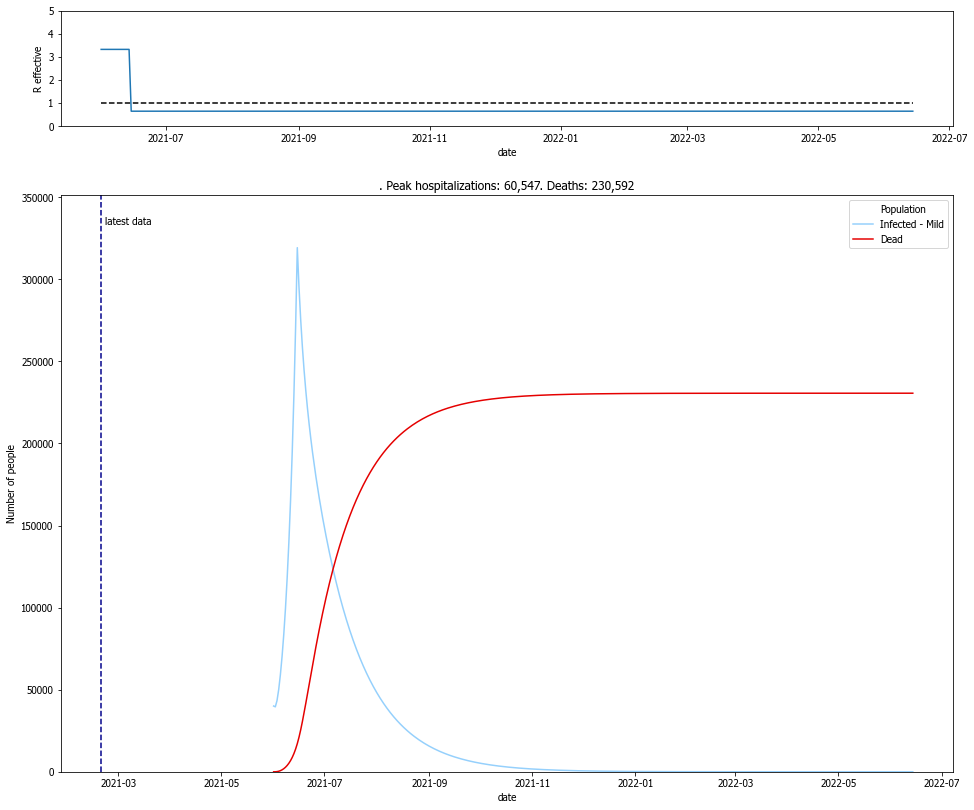

In [170]:
cols = ["infected_a", "R effective", "dead"]
prep_plot(low_display, cols, line_day=datetime(2021,2,19))

In [56]:
m3 = folium.Map(
    location=[0, 0],
    tiles='CartoDB positron',
    zoom_start=3
)

def add_marker_3(row):
    
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=row['outbreak'] / 100000,
        popup=row['country'],
        color='#FF6347',
        fill=True,
        fill_color='#FF6347',
    ).add_to(m3)
    
    return